In [107]:
import numpy as np
import scipy as sci
import math as ma
import matplotlib.pyplot as plt

%matplotlib inline

# Eikonal Equation:

Consider the evolution of a region $\partial \Omega$ in the plane as its boundary moves  inwards with speed $F(x,y)>0$. The evolution is completely determined by the arrival time 

\begin{equation}
T(x,y) = \text{time for the moving boundary to pass through} \; (x,y)
\end{equation}

This function satisfies the Hamilton-Jacobi equation

\begin{equation}
|\nabla T(x,y)| \; F(x,y) = 1 \; \; \; \text{in} \; \; \Omega
\end{equation}

where $T(x,y) = 0$ on $\partial \Omega$. 


Note that when $F(x,y)=1$, the function $T$ is characterized by the optimization

\begin{equation}
T(x) = \min_{z \in \partial \Omega} \; \text{dist}(x, z), \; \; \; x, z \in \mathbb{R}^2.
\end{equation}

In this notebook, I present a simple implementation of the Fast Marching Method for finding the (viscosity) solution to the Eikonal Equation on $[-1,1]^2 \subset \mathbb{R}^2$.  Assume for simplicity that the initial curve is given on $y=-1$, and define the speed function $F(x,y) = \exp(x^2 + y^{10})$.

## HeapSort Algorithm (max heap):

In [108]:
def iParent(i):
    return ma.floor((i-1) / 2)

def iLeftChild(i):
    return 2*i + 1

def iRightChild(i):
    return 2*i + 2



# Repair the heap whose root element is at index 'start'
# assuming the heaps rooted at its children are valid.
def siftDown(arr, start, end):
    root = start
    
    while iLeftChild(root) <= end: # While the root has at least one child
        child = iLeftChild(root) # Left child of root
        swap = root  # Keeps track of child to swap with
        
        if arr[swap] < arr[child]:
            swap = child
        
        if child+1 <= end and arr[swap] < arr[child+1]: # If there is a right child and that child is greater.
            swap = child+1
            
        if swap == root: # The root holds the largest element. Since we assume the 
            return       # heaps rooted at the children re valid, this means that we are done.
        
        else:
            arr[root], arr[swap] = arr[swap], arr[root]
            root = swap
            

# Put elements of 'arr' in heap order, in-place
def max_heapfy(arr, count):
    
    start = iParent(count-1) # Start is assigned the index in 'a' of the last parent node
                             # the last element in a 0-based array is at index count-1; 
                             # find the parent of that element.
    while start >= 0:
        # Sift down the node at index 'start' to the proper place such that all nodes below
        # the start index are in heap order.
        siftDown(arr, start, count-1)
        # Go to the next parent node
        start = start-1
        # After sifting down the root all nodes/elements are in heap order
        
        
# Main function; input: an unordered array "arr" of length "count"; 
# output: an ordered array whose elements are increasing in the index.
def max_heapSort(arr, count):
    
    # Build the heap in array a so that largest value is at the root.
    max_heapfy(arr, count)
    
    # The following loop maintains the invariants that a[0:end] is a heap and every element
    #b eyond end is greater than everything before it (so a[end:count] is in sorted order).
    end = count-1
    
    while end > 0:
        # arr[0] is the root and largest value. The swap moves it in front of the sorted elements.
        arr[end], arr[0] = arr[0], arr[end]
        # The heap size is reduced by one
        end = end-1
        # The swap ruined the heap property, so restore it
        siftDown(arr, 0, end)

## Fast Marching Implementation:

In [200]:
# A MIN-HEAP STRUCTURE FOR THE FAST MARCHING METHOD

# Repair the heap whose root element is at index 'start'
# assuming the heaps rooted at its children are valid.
def siftDown_FMM(arr, start, end):
    root = start
    
    while iLeftChild(root) <= end: # While the root has at least one child
        child = iLeftChild(root) # Left child of root
        swap = root  # Keeps track of child to swap with
        
        if arr[swap].value > arr[child].value:
            swap = child
        
        if child+1 <= end and arr[swap].value > arr[child+1].value: # If there is a right child and that child is smaller.
            swap = child+1
            
        if swap == root: # The root holds the smallest element. Since we assume the 
            return       # heaps rooted at the children re valid, this means that we are done.
        
        else:
            arr[root], arr[swap] = arr[swap], arr[root]
            root = swap
            

# Put elements of 'arr' in heap order, in-place
def min_heapfy_FMM(arr, count):
    
    start = iParent(count-1) # Start is assigned the index in 'arr' of the last parent node
                             # the last element in a 0-based array is at index count-1; 
                             # find the parent of that element.
    while start >= 0:
        # Sift down the node at index 'start' to the proper place such that all nodes below
        # the start index are in heap order.
        siftDown_FMM(arr, start, count-1)
        # Go to the next parent node
        start = start-1
        # After sifting down the root all nodes/elements are in heap order


# Main function; input: an unordered array "arr" of length "count"; 
# output: an ordered array whose elements are decreasing in the index.
def min_heapSort_FMM(arr, count):
    
    # Build the heap in array a so that min value is at the root.
    min_heapfy_FMM(arr, count)
    
    # The following loop maintains the invariants that a[0:end] is a heap and every element
    # beyond end is smaller than everything before it (so a[end:count] is in sorted order).
    end = count-1
    
    while end > 0:
        # arr[0] is the root and largest value. The swap moves it in front of the sorted elements.
        arr[end], arr[0] = arr[0], arr[end]
        # The heap size is reduced by one
        end = end-1
        # The swap ruined the heap property, so restore it
        siftDown_FMM(arr, 0, end)
        

        
        
# FAST MARCHING METHOD 

# Class that defines an object, the Node, which has 2 attributes: Location (coordinates (i,j) on the grid)
# and Value (numerical valute of the T-function at point (i,j)
class node(object):
    
    def __init__(self, node_coordinates, node_val):
        
        # Location of the node (i,j)
        self.location = node_coordinates
        
        # T[i,j] value
        self.value = node_val
        


# Create list that contains all the indexes of the (Accepted) gridpoints on the initial curve (y=-1 in this case);
# these are identified by the fact that on the initial curve T(x,y) = 0.
def accepted(T):
    
    N = T.shape[0] #length of the array that contains values of function T.
    accpt_list = [] #initialize list for accepted nodes' indexes
    
    for i in range(0, N):  # loop over entire domain
        for j in range(0, N):
            
            if T[i,j] == 0.0: # check whether value of T=0 (i.e., check if we are on the initial curve)
                accpt_list.append((i,j)) # if yes, record the index 
    
    return accpt_list


# Create list that contains the Nodes in the Narrow Bands. Each Node is an instance of the node Class,
# which means that each element of this list has attributes Location and T-Value
def narrow_band(T):
    
    N = T.shape[0]
    nb_list = []
    
    for i in range(0, N):
        for j in range(0, N):
            if T[i,j] == 0.0:
                element = node((i,j+1), T[i,j+1])
                nb_list.append(element)
    
    return nb_list


# Function that computes and returns the positive root in the Godunov approximation
# to the gradient (the norm of it) in the Eikonal Equation
def quadratic(a, b, c):
    # a and b are the values of the neighbors and c is just \delta x / F square
    # double delta
    delta = (2*c - (a-b)**2)
    
    if delta >= 0:
        d = (a + b + np.sqrt(delta))/2  
    else:
        d = 1000000000 #just a huge number
    
    return d
    
    
# Input: the node (i,j) with minimal T-value among the nodes in the narrow band
# Output: computes new T[i,j] value via Godunov Scheme,uses only information from accepted nodes
def solve_FMM(node, dx):
    
    (i, j) = node.location #location of the newly accepted node
    
    # get values of T at point (i,j) and neighbors
    Tij = T[i,j]   
    Tj = T[i-1,j]
    Tiij = T[i+1,j]
    Ti = T[i,j-1]
    Tijj = T[i,j+1]
    F_val = F[i,j] # speed value 
    c = (dx / F_val) * (dx / F_val) # constant to be used in Godunov scheme (dx/F)^2
    
    d1 = 100000000.0 # very large number
    d2 = d1
    d3 = d2 
    d4 = d3
    d5 = d4
    
    d1 = dx/F_val + np.min([np.min([Tj,Tiij]), np.min([Tijj,Ti])])
    
    if Tj < Tij and Ti < Tij:
        d2 = quadratic(Ti,Tj,c)
    
    if Ti < Tij and Tiij < Tij:
        d3 = quadratic(Ti,Tiij,c)
    
    if Tiij < Tij and Tijj < Tij:
        d4 = quadratic(Tiij,Tijj,c)
    
    if Tijj < Tij and Tj < Tij:
        d5 = quadratic(Tijj,Tj,c)
    
    T[i,j] = np.min( [np.min([d1, np.min([d2,d3])]), np.min([d4,d5])]) # updated T-value
    node.value = T[i,j]  #update value of T in the "node" instance
    
    

# Input: Narrow Band Nodes list (which has min-heap structure), Accepted Nodes list
# 1- take the 0 element in the narrow band list (=index (i,j) with minimal T-value) 
# 2- inserts (i,j) in the list of Accepted nodes
# 3- uses solve_FMM to compute the updated value at (i,j)
# 4- (if not yet included) adds neighboring nodes of (i,j) to the Narrow Band list
# 5- Heapfies the Narrow Band list once again
def update_FMM(nb_list, accpt_list, dx):
    
    if len(nb_list) > 0:
        
        accepted_node = nb_list[0]
        solve_FMM(accepted_node, dx)
        del nb_list[0]
        i, j = accepted_node.location
        accpt_list.append((i,j))
        loc_list = []
        
        for element in nb_list:
            loc_list.append(element.location)
            
        
        if (i-1, j) not in loc_list and i-1 not in (0, N-1) and j not in (0, N-1):
            if (i-1, j) not in accpt_list:
                a = node((i-1, j), T[i-1,j])
                nb_list.append(a)
        if (i, j-1) not in loc_list and i not in (0, N-1) and j-1 not in (0, N-1):
            if (i, j-1) not in accpt_list:
                b = node((i, j-1), T[i,j-1])
                nb_list.append(b)
        if (i+1, j) not in loc_list and i+1 not in (0, N-1) and j not in (0, N-1):
            if (i+1, j) not in accpt_list:
                c = node((i+1, j), T[i+1,j])
                nb_list.append(c)
        if (i, j+1) not in loc_list and i not in (0, N-1) and j+1 not in (0, N-1):
            if (i, j+1) not in accpt_list:
                d = node((i, j+1), T[i,j+1])
                nb_list.append(d)
        
        loc_list = []
        
        for element in nb_list:
            solve_FMM(element, dx)
        
        min_heapfy_FMM(nb_list, len(nb_list))
        
        
    else:
        print("Done")
        

# Loops until all nodes are Accepted
def FMM_loop(narrow_band, accpt_list, dx):
    
    i = 0
    
    while len(narrow_band) > 0:
        update_FMM(narrow_band, accpt_list, dx)
        i = i+1
        if i == 500 or i == 1000 or i == 3000 or i == 7000:
            print("Current iteration:", i)
        if len(narrow_band) == 0:
            
            print("Done, number of iterations:", i)
            break
        

In [201]:
# PARAMETERS / INITIAL DATA

dx = dy = 0.05 #grid step
X = np.arange(-1.0-dx, +1.0+dx, dx)
Y = np.arange(-1.0-dx, +1.0+dx, dx)
Xm, Ym = np.meshgrid(X, Y) # grid mesh

M = len(X)
N = len(Y)

#Set initial values for T (T=0 when y=-1, T=infinity otherwise)
def T_initial():
    
    XX = np.arange(-1.0, +1.0, dx)
    
    N = X.shape[0]
    initial_T = np.full(shape=(N, N), fill_value=1000000000.0)
    initial_T[1:N-1,1] = 0.0
    
    return initial_T
            
# Speed function
def F_fn(x, y):
    
    return np.exp((x**2.0 + y**10.0))

In [191]:
T = T_initial()
F = F_fn(Xm, Ym)
nb = narrow_band(T)
acc = accepted(T)

In [192]:
FMM_loop(nb, acc, dx)

Current iteration: 500
Current iteration: 1000
Done, number of iterations: 1560


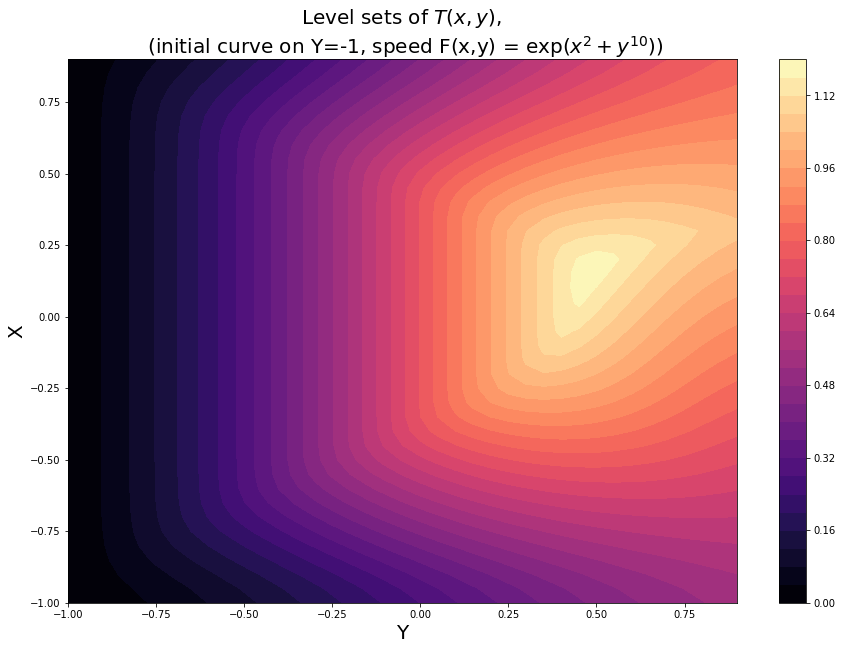

In [198]:
fig, ax = plt.subplots(figsize=(15,10))
plt.contourf(X[1:N-2],Y[1:N-2],T[1:N-2,1:N-2],30, cmap="magma")
plt.colorbar()
plt.title("Level sets of $T(x,y)$, \n (initial curve on Y=-1, speed F(x,y) = $\exp(x^2 + y^{10})$)", fontsize=20)
plt.xlabel("Y", fontsize=20)
plt.ylabel("X", fontsize=20)
plt.show()

Copyright & copy; 2019, Ildebrando Magnani.
All Rights reserved.